## Incremental Deep Learning for Image Classification

This notebook implements an incremental learning approach for image classification using deep learning. The idea is to train a deep learning model on a small dataset and then incrementally train the model on new data.

## Table of Contents

1. [Setup and Imports](#setup)
2. [Data Pipeline](#data-pipeline)
3. [Model Architecture](#model-architecture)
4. [Training Pipeline](#training)
5. [Evaluation](#evaluation)
6. [Results](#results)


### 1. Setup and Imports <a id='setup'></a>

Configures logging and import required libraries


In [22]:
import json
import logging
from dataclasses import dataclass
from datetime import datetime
from itertools import cycle
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.metrics import (
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

#### Configuration


In [23]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [24]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [25]:
tf.random.set_seed(42)
np.random.seed(42)

##### Visualization


In [26]:
sns.set_theme(style="whitegrid")

## 2. Data Pipeline <a id='data-pipeline'></a>


Configures the data split object


In [27]:
@dataclass
class DataSplit:
    train_paths: List[str]
    val_paths: List[str]
    test_paths: List[str]
    class_mapping: Dict[str, int]
    num_classes: int

### Data Manager


In [28]:
class DataManager:
    def __init__(
        self,
        base_path: str,
        img_size: Tuple[int, int] = (224, 224),
        val_split: float = 0.15,
        test_split: float = 0.15,
        random_seed: int = 42,
    ):
        self.data_dir = Path(base_path)
        self.img_size = img_size
        self.val_split = val_split
        self.test_split = test_split

        self.seed = random_seed
        self.class_counts = self._get_class_counts()
        self.sorted_classes = self._sort_classes_by_size()
        self.class_mapping = self._create_class_mapping()

    def _get_class_counts(self) -> Dict[str, int]:
        """
        Counts the number of images in each class directory.
        """

        class_counts: dict = {}
        if not self.data_dir.exists():
            raise ValueError(f"Data directory {self.data_dir} does not exist.")

        for class_dir in self.data_dir.iterdir():
            if class_dir.is_dir():
                class_counts[class_dir.name] = len(list(class_dir.glob("*.jpg")))

        return class_counts

    def _sort_classes_by_size(self) -> List[str]:
        """
        Sorts the classes by the number of images in each class.

        Returns:
          List[str]: List of class names sorted by the number of images in each class.
        """

        return sorted(
            self.class_counts.keys(),
            key=lambda x: (self.class_counts[x], int(x)),
            reverse=True,
        )

    def _create_class_mapping(self) -> Dict[str, int]:
        """
        Creates a mapping from class names to class indices.

        Returns:
          Dict[str, int]: Dictionary mapping class names to class indices.
        """

        return {class_name: int(class_name) for class_name in self.class_counts.keys()}

    def get_class_subset(self, num_classes: int) -> List[str]:
        """
        Gets the top `num_classes` classes sorted by the number of images in each class.

        Args:
          num_classes (int): Number of classes to include in the dataset.

        Returns:
          List[str]: List of class names.
        """

        if num_classes > len(self.sorted_classes):
            raise ValueError(
                f"Requested {num_classes} classes, but only {len(self.sorted_classes)} available."
            )

        return self.sorted_classes[:num_classes]

    def _collect_image_paths(self, classes: List[str]) -> Tuple[List[str], List[str]]:
        """
        Collects all image paths and their corresponding labels for the
        given classes.

        Args:
          classes (List[str]): List of class names to include in the dataset.

        Returns:
          Tuple[List[str], List[str]]: Tuple containing the image paths and their corresponding labels.
        """

        image_paths, labels = [], []

        for class_name in classes:
            class_path = self.data_dir / class_name

            if not class_path.exists():
                logger.warning(f"Class directory {class_path} does not exist.")
                continue

            image_files = []
            for ext in ["*.jpg"]:
                image_files.extend(list(class_path.glob(ext)))

            if not image_files:
                logger.warning(f"No images found in {class_path}")
                continue

            image_paths.extend([str(img) for img in image_files])
            labels.extend([class_name] * len(image_files))

            logger.info(f"Collected {len(image_files)} images for class {class_name}")

            if not image_paths:
                raise ValueError(f"No images found for classes {classes}")

        return image_paths, labels

    def prepare_data_split(self, classes: List[str]) -> DataSplit:
        """
        Prepares the data split for the given classes. It first
        divides the data into train_val and test sets, and then
        further divides the train_val set into train and validation

        Args:
            classes (List[str]): List of class names to include in the dataset.

        Returns:
            DataSplit: DataSplit object containing the train, validation, and test splits.
        """

        image_paths, labels = self._collect_image_paths(classes)
        subset_mapping = {cls: self.class_mapping[cls] for cls in classes}

        train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
            image_paths,
            labels,
            test_size=self.test_split,
            stratify=labels,
            random_state=self.seed,
        )

        train_paths, val_paths, train_labels, val_labels = train_test_split(
            train_val_paths,
            train_val_labels,
            test_size=self.val_split / (1 - self.test_split),
            stratify=train_val_labels,
            random_state=self.seed,
        )

        logger.info(
            f"Split sizes - Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}"
        )

        return DataSplit(
            train_paths=train_paths,
            val_paths=val_paths,
            test_paths=test_paths,
            class_mapping=subset_mapping,
            num_classes=len(classes),
        )

    def plot_class_distribution(self, classes: Optional[List[str]] = None):
        """
        Plots the class distribution for the given classes.

        Args:
            clases (Optional[List[str]]): List of class names to include in the plot.
        """

        if classes is None:
            classes = self.sorted_classes

        counts = [self.class_counts[cls] for cls in classes]
        plt.figure(figsize=(12, 6))
        plt.bar(classes, counts)
        plt.title("Class Distribution")
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### Data Generator


In [29]:
class DataGenerator:
    def __init__(self, img_size: Tuple[int, int], batch_size: int = 32):
        self.img_size = img_size
        self.batch_size = batch_size
        self.train_datagen = self._create_train_datagen()
        self.test_datagen = self._create_test_datagen()
        self.label_to_index = None
        self.num_classes = None

    def _create_train_datagen(self) -> tf.keras.preprocessing.image.ImageDataGenerator:
        """
        Creates the training data generator with data augmentation. The following augmentations are applied:
        - Rotation
        - Width and height shift
        - Shear
        - Zoom
        - Horizontal and vertical flip
        - Brightness

        Returns:
            tf.keras.preprocessing.image.ImageDataGenerator: Training data generator.
        """

        return tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=360,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode="constant",
            brightness_range=(0.6, 1.4),
            channel_shift_range=0.2,
        )

    def _create_test_datagen(self) -> tf.keras.preprocessing.image.ImageDataGenerator:
        """
        Creates the test data generator with only the input preprocessing function.

        Returns:
            tf.keras.preprocessing.image.ImageDataGenerator: Test data generator
        """

        return tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self._preprocess_input,
        )

    def _preprocess_input(self, x):
        """
        Preprocesses the input image by scaling pixel values to the range of [-1, 1].

        Args:
            x (np.ndarray): Input image.

        Returns:
            np.ndarray: Preprocessed image.
        """

        x = tf.cast(x, tf.float32)

        return tf.image.per_image_standardization(x)

    def create_generators(self, data_split: DataSplit):
        """
        Creates the generators for training, validation, and testing.

        Args:
            data_split (DataSplit): DataSplit object containing the train, validation, and test splits.

        Returns:
            Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]: Tuple containing the training, validation, and test datasets.
        """

        self.label_to_index = data_split.class_mapping
        self.num_classes = data_split.num_classes

        def create_df(paths: List[str]) -> pd.DataFrame:
            return pd.DataFrame(
                {
                    "filename": paths,
                    "class": [Path(p).parent.name for p in paths],
                }
            )

        train_df = create_df(data_split.train_paths)
        val_df = create_df(data_split.val_paths)
        test_df = create_df(data_split.test_paths)

        logger.info(
            f"Training set class distribution:\n{train_df['class'].value_counts()}"
        )

        train_ds = self._create_dataset(train_df, is_training=True)
        val_ds = self._create_dataset(val_df, is_training=False)
        test_ds = self._create_dataset(test_df, is_training=False)

        return train_ds, val_ds, test_ds

    def _create_dataset(
        self, df: pd.DataFrame, is_training: bool = False
    ) -> tf.data.Dataset:
        """
        Creates the tf.data.Dataset object from the given DataFrame.

        Args:
            df (pd.DataFrame): DataFrame containing the image paths and their corresponding labels.
            is_training (bool): Whether the dataset is for training or not.

        Returns:
            tf.data.Dataset: Dataset object.
        """

        datagen = self.train_datagen if is_training else self.test_datagen
        filenames = df["filename"].values
        labels = df["class"].map(self.label_to_index).values

        dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
        dataset = dataset.map(self._parse_function, num_parallel_calls=tf.data.AUTOTUNE)

        dataset = dataset.batch(self.batch_size)

        if is_training:
            dataset = dataset.shuffle(
                buffer_size=len(df), reshuffle_each_iteration=True
            )

        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        steps = len(df) // self.batch_size
        if is_training:
            self.steps_per_epoch = steps

        else:
            self.validation_steps = steps

        return dataset

    @tf.function
    def _parse_function(self, filename, label):
        """
        Loads and preprocesses the image and its corresponding label.

        Args:
            filename (tf.Tensor): Image filename.
            label (tf.Tensor): Image label.

        Returns:
            Tuple[tf.Tensor, tf.Tensor]: Tuple containing the image and its label
        """

        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, self.img_size)
        label = tf.one_hot(label, self.num_classes)

        return image, label

    def get_steps(self) -> Tuple[int, int]:
        """
        Gets the number of steps per epoch and validation steps.

        Returns:
            Tuple[int, int]: Tuple containing the steps per epoch and validation steps.
        """

        return self.steps_per_epoch, self.validation_steps

    def get_num_classes(self) -> int:
        """
        Gets the number of classes in the dataset.

        Returns:
            int: Number of classes.
        """

        return self.num_classes

    def get_class_mapping(self) -> Dict[str, int]:
        """
        Gets the class mapping.

        Returns:
            Dict[str, int]: Dictionary mapping class names to class indices.
        """

        return self.label_to_index

## Pre-Trained Model


In [30]:
f1_score_metric = tf.keras.metrics.F1Score(
    average="macro", threshold=None, name="f1_score"
)


@keras.saving.register_keras_serializable()
def sparse_f1_score(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """
    Custom sparse f1 score function for multi-class classification.

    Args:
        y_true (tf.Tensor): True labels.
        y_pred (tf.Tensor): Predicted labels.

    Returns:
        tf.Tensor: Sparse f1 score.
    """

    return f1_score_metric(y_true, y_pred)

In [31]:
@keras.saving.register_keras_serializable()
class ModelManager:
    def __init__(
        self,
        img_size: Tuple[int, int] = (224, 224),
        model_dir: str = "models",
        initial_lr: float = 1e-4,
    ):
        self.img_size = img_size
        self.model_dir = Path(model_dir)
        self.model_dir.mkdir(exist_ok=True, parents=True)
        self.initial_lr = initial_lr
        self.model = None
        self.base_model = None

    def build_model(self, num_classes: int) -> tf.keras.Model:
        """
        Builds the DenseNet169 model with the given number of classes.

        Args:
            num_classes (int): Number of classes.

        Returns:
            tf.keras.Model: Model with the given number of classes.
        """

        if self.model is None:
            self.base_model = tf.keras.applications.MobileNetV3Large(
                weights="imagenet", include_top=False, input_shape=(*self.img_size, 3)
            )

            self.base_model.trainable = False

            inputs = tf.keras.Input(shape=(*self.img_size, 3))
            x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)

            x = self.base_model(x, training=False)
            x1 = tf.keras.layers.GlobalAveragePooling2D()(x)
            x2 = tf.keras.layers.GlobalMaxPooling2D()(x)

            x = tf.keras.layers.Concatenate()([x1, x2])
            x = tf.keras.layers.Dense(512, use_bias=False)(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation("relu")(x)
            x = tf.keras.layers.Dropout(0.5)(x)

            x = tf.keras.layers.Dense(256, activation="relu")(x)
            x = tf.keras.layers.Dropout(0.3)(x)
            outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

            self.model = tf.keras.Model(inputs, outputs)

        self.current_classes = num_classes
        self._compile_model()
        return self.model

    def _compile_model(self):
        """
        Compiles the model with the given number of classes.

        Returns:
            tf.keras.Model: Compiled model.
        """
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.initial_lr, clipnorm=1.0
        )

        self.model.compile(
            optimizer=optimizer,
            loss="categorical_crossentropy",
            metrics=["accuracy", sparse_f1_score],
        )

    def train(
        self,
        train_ds,
        val_ds,
        iteration: int,
        epochs: int = 50,
        class_weights: Optional[Dict] = None,
    ) -> tf.keras.callbacks.History:
        """
        Trains the model on the given training and validation datasets.

        Args:
            train_ds (tf.data.Dataset): Training dataset.
            val_ds (tf.data.Dataset): Validation dataset.
            iteration (int): Iteration number.
            epochs (int): Number of epochs.
            class_weights (Optional[Dict]): Class weights for the loss function.

        Returns:
            tf.keras.callbacks.History: Training history.
        """

        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                str(self.model_dir / f"best_model_iter_{iteration}.keras"),
                monitor="val_accuracy",
                mode="max",
                save_best_only=True,
                verbose=1,
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=10,
                restore_best_weights=True,
                verbose=1,
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
            ),
        ]

        history = self.model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=callbacks,
            class_weight=class_weights,
        )

        self.model.save(str(self.model_dir / f"model_iter_{iteration}.keras"))
        return history

    def prepare_next_iteration(
        self, previous_iteration: int, new_num_classes: int
    ) -> None:
        """
        Prepares the next iteration of the model by loading the best model from the previous iteration and updating the output layer to match the new number of classes.

        Args:
            previous_iteration (int): Previous iteration number.
            new_num_classes (int): Number of classes for the new iteration.
        """

        self.load_best_model(str(previous_iteration))
        old_dense = self.model.layers[-1]
        old_weights = old_dense.get_weights()

        self.build_model(new_num_classes)
        new_dense = self.model.layers[-1]
        new_weights = new_dense.get_weights()

        new_weights[0][: old_weights[0].shape[0], :] = old_weights[0]
        new_weights[1][: old_weights[1].shape[0]] = old_weights[1]
        new_dense.set_weights(new_weights)

        logger.info(
            f"Prepared next iteration with {new_num_classes} classes from iteration {previous_iteration}"
        )

    def load_best_model(self, iteration: str) -> None:
        """
        Loads the best model from the given iteration.

        Args:
            iteration (str): Iteration number.

        Raises:
            ValueError: If no saved model is found for the given iteration.
        """

        model_path = self.model_dir / f"best_model_iter_{iteration}.keras"
        if not model_path.exists():
            raise ValueError(f"No saved model found for iteration {iteration}")

        custom_objects = {"sparse_f1_score": sparse_f1_score}
        self.model = tf.keras.models.load_model(
            str(model_path), custom_objects=custom_objects
        )

        logger.info(f"Loaded best model from iteration {iteration}")

    def save_iteration_info(self, iteration: int, metrics: Dict) -> None:
        """
        Saves the iteration information to a JSON file.

        Args:
            iteration (int): Iteration number.
            metrics (Dict): Metrics for the iteration.

        Raises:
            ValueError: If the model has not been trained yet.
        """

        info = {
            "iteration": iteration,
            "metrics": metrics,
            "model_config": self.model.get_config(),
            "timestamp": datetime.now().isoformat(),
        }

        with open(self.model_dir / f"iteration_{iteration}_info.json", "w") as f:
            json.dump(info, f, indent=4)

    def get_config(self) -> Dict:
        """
        Gets the configuration of the model.

        Returns:
            Dict: Model configuration.
        """

        return self.model.get_config()

### Auxiliary function


In [32]:
def plot_history_subplot(history: tf.keras.callbacks.History):
    """
    Plots the training history with the accuracy, loss, and f1-score subplots.

    Args:
        history (tf.keras.callbacks.History): Training history.
    """

    fig = plt.figure(figsize=(15, 5))

    ax1 = plt.subplot(1, 3, 1)
    ax1.plot(history.history["accuracy"], label="Training")
    ax1.plot(history.history["val_accuracy"], label="Validation")
    ax1.set_title("Model Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(True)

    ax2 = plt.subplot(1, 3, 2)
    ax2.plot(history.history["loss"], label="Training")
    ax2.plot(history.history["val_loss"], label="Validation")
    ax2.set_title("Model Loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True)

    ax3 = plt.subplot(1, 3, 3)
    ax3.plot(history.history["sparse_f1_score"], label="Training")
    ax3.plot(history.history["val_sparse_f1_score"], label="Validation")
    ax3.set_title("Model F1 Score")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("F1 Score")
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

In [33]:
class ModelEvaluator:
    def __init__(self, model_manager: ModelManager):
        self.model_manager = model_manager
        self.evaluation_history: Dict[int, Dict] = {}

    def evaluate_iteration(
        self,
        iteration: int,
        test_ds: tf.data.Dataset,
        class_names: List[str],
        plot: bool = True,
    ) -> Dict:
        """
        Evaluates the current iteration of the model on the test dataset.

        Args:
            iteration (int): Iteration number.
            test_ds (tf.data.Dataset): Test dataset.
            class_names (List[str]): List of class names.
            plot (bool): Whether to plot the evaluation results.

        Returns:
            Dict: Evaluation results
        """

        y_pred_proba = []
        y_pred = []
        y_true = []

        for images, labels in test_ds:
            predictions = self.model_manager.model.predict(images)

            y_pred_proba.extend(predictions)
            y_pred.extend(np.argmax(predictions, axis=1))
            y_true.extend(np.argmax(labels, axis=1))

        y_pred_proba = np.array(y_pred_proba)
        y_true_onehot = tf.one_hot(y_true, depth=len(class_names))

        cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
        report = classification_report(
            y_true, y_pred, labels=range(len(class_names)), output_dict=True
        )

        results = {
            "confusion_matrix": cm,
            "classification_report": report,
            "class_names": class_names,
            "y_true": y_true_onehot,
            "y_pred_proba": y_pred_proba,
        }

        self.evaluation_history[iteration] = results

        if plot:
            self.plot_confusion_matrix(iteration)
            self.plot_roc_curves(iteration)
            self.plot_precision_recall_curves(iteration)

        return results

    def plot_roc_curves(self, iteration: int) -> None:
        """
        Plots the ROC curves for each class in the given iteration. The ROC curves represent the true positive rate (sensitivity) against the false
        cumulative positive rate (1-specificity) for different thresholds.

        Args:
            iteration (int): Iteration number.

        Raises:
            ValueError: If the iteration results are not found
        """

        results = self.evaluation_history[iteration]
        y_true = results["y_true"]
        y_pred_proba = results["y_pred_proba"]
        class_names = results["class_names"]

        plt.figure(figsize=(10, 8))
        colors = plt.cm.tab20(np.linspace(0, 1, len(class_names)))

        for i, (color, class_name) in enumerate(zip(colors, class_names)):
            try:
                fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(
                    fpr,
                    tpr,
                    color=color,
                    lw=2,
                    label=f"ROC curve {class_name} (AUC = {roc_auc:.2f})",
                )

            except Exception as e:
                print(f"Warning: Could not plot ROC curve for class {class_name}: {e}")

        plt.plot([0, 1], [0, 1], "k--", lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curves - Iteration {iteration}")
        plt.legend(loc="lower right")
        plt.show()

    def plot_precision_recall_curves(self, iteration: int) -> None:
        """
        Plots the precision-recall curves for each class in the given iteration. The precision-recall curves represent the precision against the recall for different thresholds.

        Args:
            iteration (int): Iteration number.

        Raises:
            ValueError: If the iteration results are not found
        """

        results = self.evaluation_history[iteration]
        y_true = results["y_true"]
        y_pred_proba = results["y_pred_proba"]
        class_names = results["class_names"]

        plt.figure(figsize=(10, 8))
        colors = plt.cm.tab20(np.linspace(0, 1, len(class_names)))

        for i, (color, class_name) in enumerate(zip(colors, class_names)):
            try:
                precision, recall, _ = precision_recall_curve(
                    y_true[:, i], y_pred_proba[:, i]
                )

                avg_precision = average_precision_score(
                    y_true[:, i], y_pred_proba[:, i]
                )

                plt.plot(
                    recall,
                    precision,
                    color=color,
                    lw=2,
                    label=f"PR curve {class_name} (AP = {avg_precision:.2f})",
                )

            except Exception as e:
                print(f"Warning: Could not plot PR curve for class {class_name}: {e}")

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curves - Iteration {iteration}")
        plt.legend(loc="lower left")
        plt.show()

    def plot_confusion_matrix(
        self, iteration: int, figsize: Tuple[int, int] = (20, 8), cmap: str = "Blues"
    ) -> None:
        """
        Plots the confusion matrix for the given iteration.

        Args:
            iteration (int): Iteration number.
            figsize (Tuple[int, int]): Figure size.
            cmap (str): Colormap. Default is "Blues".
        """

        results = self.evaluation_history[iteration]
        cm = results["confusion_matrix"]
        class_names = results["class_names"]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        cm_normalized = np.nan_to_num(cm_normalized)

        sns.heatmap(
            cm_normalized,
            annot=True,
            fmt=".2f",
            cmap=cmap,
            xticklabels=class_names,
            yticklabels=class_names,
            ax=ax1,
        )
        ax1.set_title(f"Normalized Confusion Matrix - Iteration {iteration}")
        ax1.set_ylabel("True Label")
        ax1.set_xlabel("Predicted Label")
        plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap=cmap,
            xticklabels=class_names,
            yticklabels=class_names,
            ax=ax2,
        )
        ax2.set_title(f"Raw Counts Confusion Matrix - Iteration {iteration}")
        ax2.set_ylabel("True Label")
        ax2.set_xlabel("Predicted Label")
        plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

        plt.tight_layout()
        plt.show()

    def print_classification_report(self, iteration: int) -> None:
        """
        Prints the classification report for the given iteration.

        Args:
            iteration (int): Iteration number.
        """

        report = self.evaluation_history[iteration]["classification_report"]
        class_names = self.evaluation_history[iteration]["class_names"]

        print(f"\nClassification Report - Iteration {iteration}")
        print("-" * 60)

        for i, class_name in enumerate(class_names):
            if str(i) in report:
                metrics = report[str(i)]
                print(
                    f"{class_name::<15} Precision: {metrics['precision']:.3f}  "
                    f"Recall: {metrics['recall']:.3f}  "
                    f"F1-score: {metrics['f1-score']:.3f}"
                )

        print("-" * 60)
        print(f"Accuracy: {report['accuracy']:.3f}")
        print(f"Macro avg F1-Score: {report['macro avg']['f1-score']:.3f}")
        print(f"Weighted avg F1-Score: {report['weighted avg']['f1-score']:.3f}")

In [34]:
def compare_iterations_performance(evaluator, iterations=[1, 2]):
    """
    Compares two iterations of the model by plotting the F1 score and precision by class.

    Args:
        evaluator (ModelEvaluator): ModelEvaluator object.
        iterations (List[int]): List of iteration numbers to compare.

    Raises:
        ValueError: If the iteration results are not found.
    """

    plt.figure(figsize=(15, 6))

    for iteration in iterations:
        if iteration in evaluator.evaluation_history:
            report = evaluator.evaluation_history[iteration]["classification_report"]
            classes = evaluator.evaluation_history[iteration]["class_names"]

            f1_scores = []
            accuracies = []
            for class_name in classes:
                class_idx = str(classes.index(class_name))
                if class_idx in report:
                    f1_scores.append(report[class_idx]["f1-score"])
                    accuracies.append(report[class_idx]["precision"])

            plt.subplot(1, 2, 1)
            plt.plot(
                range(len(classes)),
                f1_scores,
                marker="o",
                label=f"Iteration {iteration}",
            )
            plt.xticks(range(len(classes)), classes, rotation=45)
            plt.ylabel("F1 Score")
            plt.title("F1 Score by Class")
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(
                range(len(classes)),
                accuracies,
                marker="o",
                label=f"Iteration {iteration}",
            )
            plt.xticks(range(len(classes)), classes, rotation=45)
            plt.ylabel("Precision")
            plt.title("Precision by Class")
            plt.legend()

    plt.tight_layout()
    plt.show()

## Main Execution


In [35]:
dataset_manager = DataManager(
    base_path="../../../data/extended/day/", img_size=(224, 224)
)

data_generator = DataGenerator(img_size=(224, 224), batch_size=32)
model_manager = ModelManager(img_size=(224, 224), model_dir="saved_models")

In [36]:
evaluator = ModelEvaluator(model_manager)

## First Execution


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


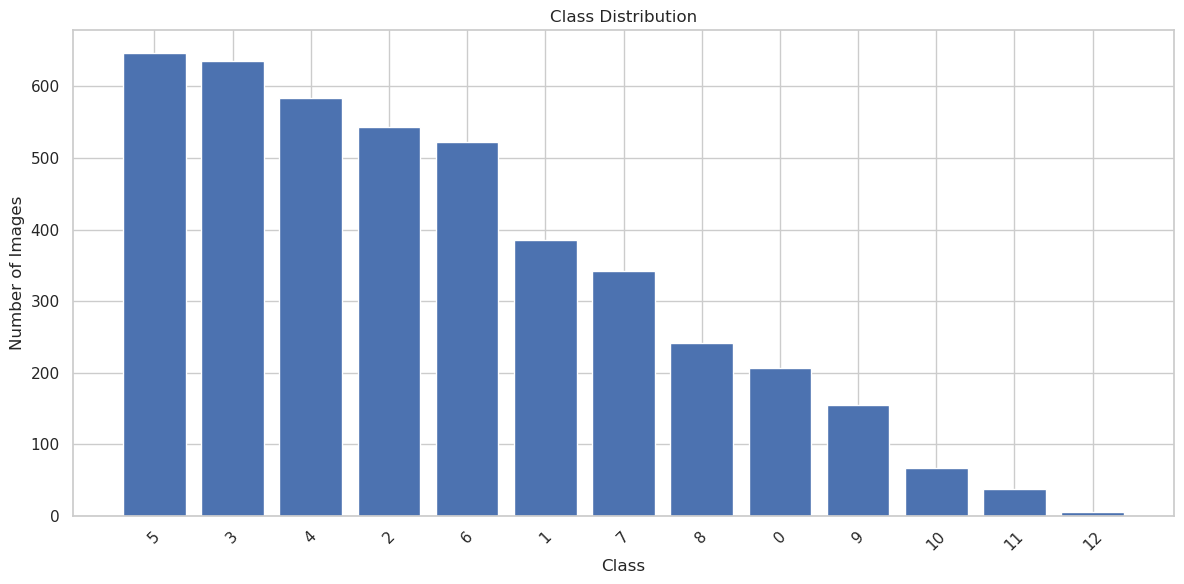

In [37]:
dataset_manager.plot_class_distribution()

## Train Iteratively


In [38]:
def prepare_next_iteration(
    model_manager: ModelManager, previous_iteration: int, new_num_classes: int
):
    """
    Prepares the next iteration of the model by loading the best model
    from the previous iteration and building a new model with the updated
    weights.

    Args:
        model_manager (ModelManager): ModelManager object.
        previous_iteration (int): Previous iteration number.
        new_num_classes (int): Number of classes in the new iteration.
    """

    model_path = model_manager.model_dir / f"best_model_iter_{previous_iteration}.keras"

    if not model_path.exists():
        not ValueError(f"No saved model found for iteration {previous_iteration}")

    custom_objects = {
        "sparse_f1_score": sparse_f1_score,
    }

    model_manager.model = tf.keras.models.load_model(
        str(model_manager.model_dir / f"best_model_iter_{previous_iteration}.keras"),
        custom_objects=custom_objects,
    )

    old_weights = [layer.get_weigths() for layer in model_manager.model.layers[:-1]]
    model_manager.build_model(new_num_classes)

    for layer, weights in zip(model_manager.model.layers[:-1], old_weights):
        if weights:
            layer.set_weights(weights)

In [39]:
def calculate_balanced_weights(dataset_manager, current_classes, previous_classes=None):
    """
    Calculates the balanced weights of the classes for the loss function.

    Args:
        dataset_manager (DataManager): DataManager object.
        current_classes (List[str]): List of current class names.
        previous_classes (Optional[List[str]]): List of previous class names.

    Returns:
        Dict: Dictionary containing the class indices and
    """

    total_samples = sum(dataset_manager.class_counts[cls] for cls in current_classes)

    weights = {}

    for cls in current_classes:
        base_weight = total_samples / (
            len(current_classes) * dataset_manager.class_counts[cls]
        )

        if previous_classes and cls in previous_classes:
            weights[int(cls)] = base_weight * 1.5

        else:
            weights[int(cls)] = base_weight

    return weights

In [40]:
def train_iteratively(
    dataset_manager: DataManager,
    model_manager: ModelManager,
    data_generator: DataGenerator,
    evaluator: ModelEvaluator,
    initial_class_count: int = 7,
    final_classes_count: int = 13,
    classes_per_iteration: int = 2,
    epochs: int = 100,
):
    """
    Trains the model until the final number of classes is reached. The model is trained iteratively by adding `classes_per_iteration` classes in each iteration.

    Args:
        dataset_manager (DataManager): DataManager object.
        model_manager (ModelManager): ModelManager object.
        data_generator (DataGenerator): DataGenerator object.
        evaluator (ModelEvaluator): ModelEvaluator object.
        initial_class_count (int): Initial number of classes to start with.
                                   Default is 7.
        final_classes_count (int): Final number of classes to reach.
                                   Default is 13.
        classes_per_iteration (int): Number of classes to add in
                                     each iteration. Default is 2.
        epochs (int): Number of epochs to train the model. Default is 100

    Raises:
        ValueError: If the number of classes to add in each iteration is greater than the final number of classes.
    """

    classes_trained = initial_class_count
    iteration = 1
    previous_classes = []

    while classes_trained <= final_classes_count:
        print(f"\n{'='*20} Iteration {iteration} {'='*20}")
        current_classes = dataset_manager.get_class_subset(num_classes=classes_trained)

        new_classes = [cls for cls in current_classes if cls not in previous_classes]
        print(f"Previous classes: {previous_classes}")
        print(f"New classes: {new_classes}")

        data_split = dataset_manager.prepare_data_split(current_classes)
        train_gen, val_gen, test_gen = data_generator.create_generators(data_split)

        print(f"Dataset manager classes: {data_split.num_classes}")

        total_samples = sum(
            dataset_manager.class_counts[cls] for cls in current_classes
        )

        class_weights = {}
        for cls in current_classes:
            base_weight = total_samples / (
                len(current_classes) * dataset_manager.class_counts[cls]
            )

            if cls in new_classes:
                class_weights[int(cls)] = base_weight * 2.0

            else:
                class_weights[int(cls)] = base_weight

        print(f"Class weights: {class_weights}")
        print(f"Training on classes: {current_classes}")

        if iteration == 1:
            model = model_manager.build_model(len(current_classes))

        else:
            model_manager.prepare_next_iteration(iteration - 1, len(current_classes))

            for layer in model_manager.model.layers[-5:]:
                layer.trainable = True

        history = model_manager.train(
            train_gen,
            val_gen,
            iteration=iteration,
            epochs=epochs,
            class_weights=class_weights,
        )

        plot_history_subplot(history)
        evaluation_results = evaluator.evaluate_iteration(
            iteration, test_gen, current_classes, plot=True
        )

        if iteration > 1:
            unfreeze_layers = min(
                5 * (iteration - 1), len(model_manager.base_model.layers)
            )

            for layer in model_manager.base_model.layers[-unfreeze_layers:]:
                layer.trainable = True

            compare_iterations_performance(evaluator, [iteration - 1, iteration])

        previous_classes = current_classes.copy()
        classes_trained += classes_per_iteration
        iteration += 1

        model_manager.save_iteration_info(
            iteration, evaluation_results["classification_report"]
        )

INFO:__main__:Collected 646 images for class 5
INFO:__main__:Collected 635 images for class 3
INFO:__main__:Collected 584 images for class 4
INFO:__main__:Collected 543 images for class 2
INFO:__main__:Collected 522 images for class 6
INFO:__main__:Collected 385 images for class 1
INFO:__main__:Collected 342 images for class 7
INFO:__main__:Split sizes - Train: 2559, Val: 549, Test: 549
INFO:__main__:Training set class distribution:
class
5    452
3    445
4    408
2    379
6    366
1    269
7    240
Name: count, dtype: int64



==================== Iteration 1 ====================
Previous classes: []
New classes: ['5', '3', '4', '2', '6', '1', '7']
Dataset manager classes: 7
Class weights: {5: 1.6174259177355153, 3: 1.6454443194600674, 4: 1.7891389432485323, 2: 1.9242304656669298, 6: 2.0016420361247946, 1: 2.7139146567717995, 7: 3.055137844611529}
Training on classes: ['5', '3', '4', '2', '6', '1', '7']
Epoch 1/100
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.1925 - loss: 4.2922 - sparse_f1_score: 0.1179
Epoch 1: val_accuracy improved from -inf to 0.30783, saving model to saved_models/best_model_iter_1.keras
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step - accuracy: 0.1933 - loss: 4.2784 - sparse_f1_score: 0.1187 - val_accuracy: 0.3078 - val_loss: 1.4590 - val_sparse_f1_score: 0.2139 - learning_rate: 1.0000e-04
Epoch 2/100
76/80 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2874 - loss: 2.8975 - sparse_f1_score: 0.2272
Epoch 2: val_accuracy improved from 0.30783 to 0.38798, saving model to saved_model

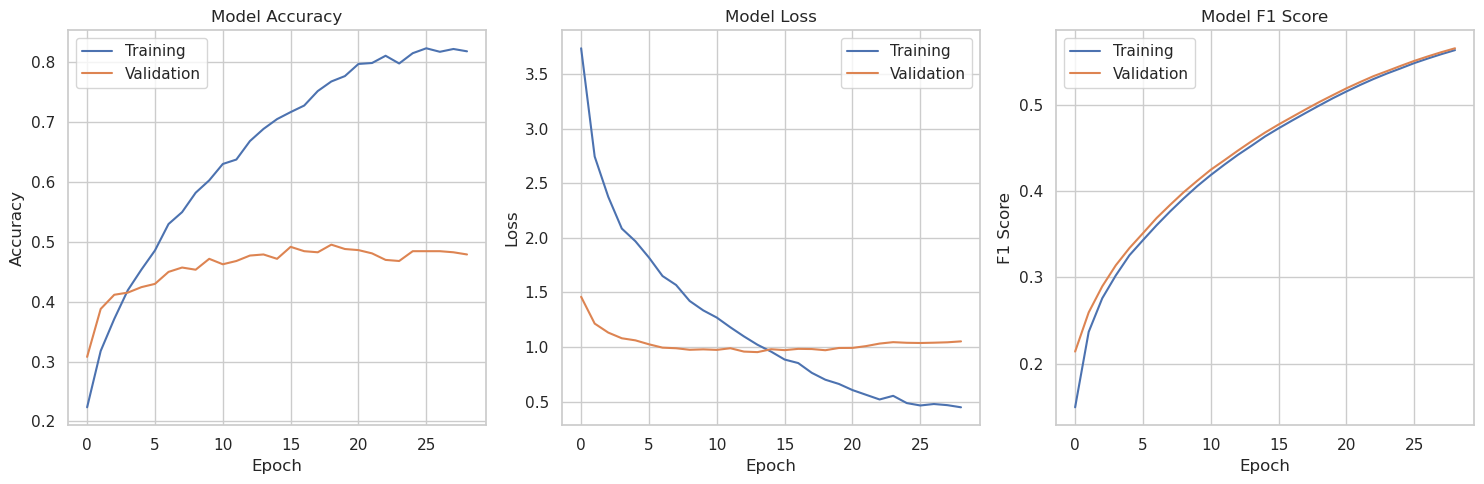

2024-11-27 12:11:16.030397: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


2024-11-27 12:11:23.189663: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

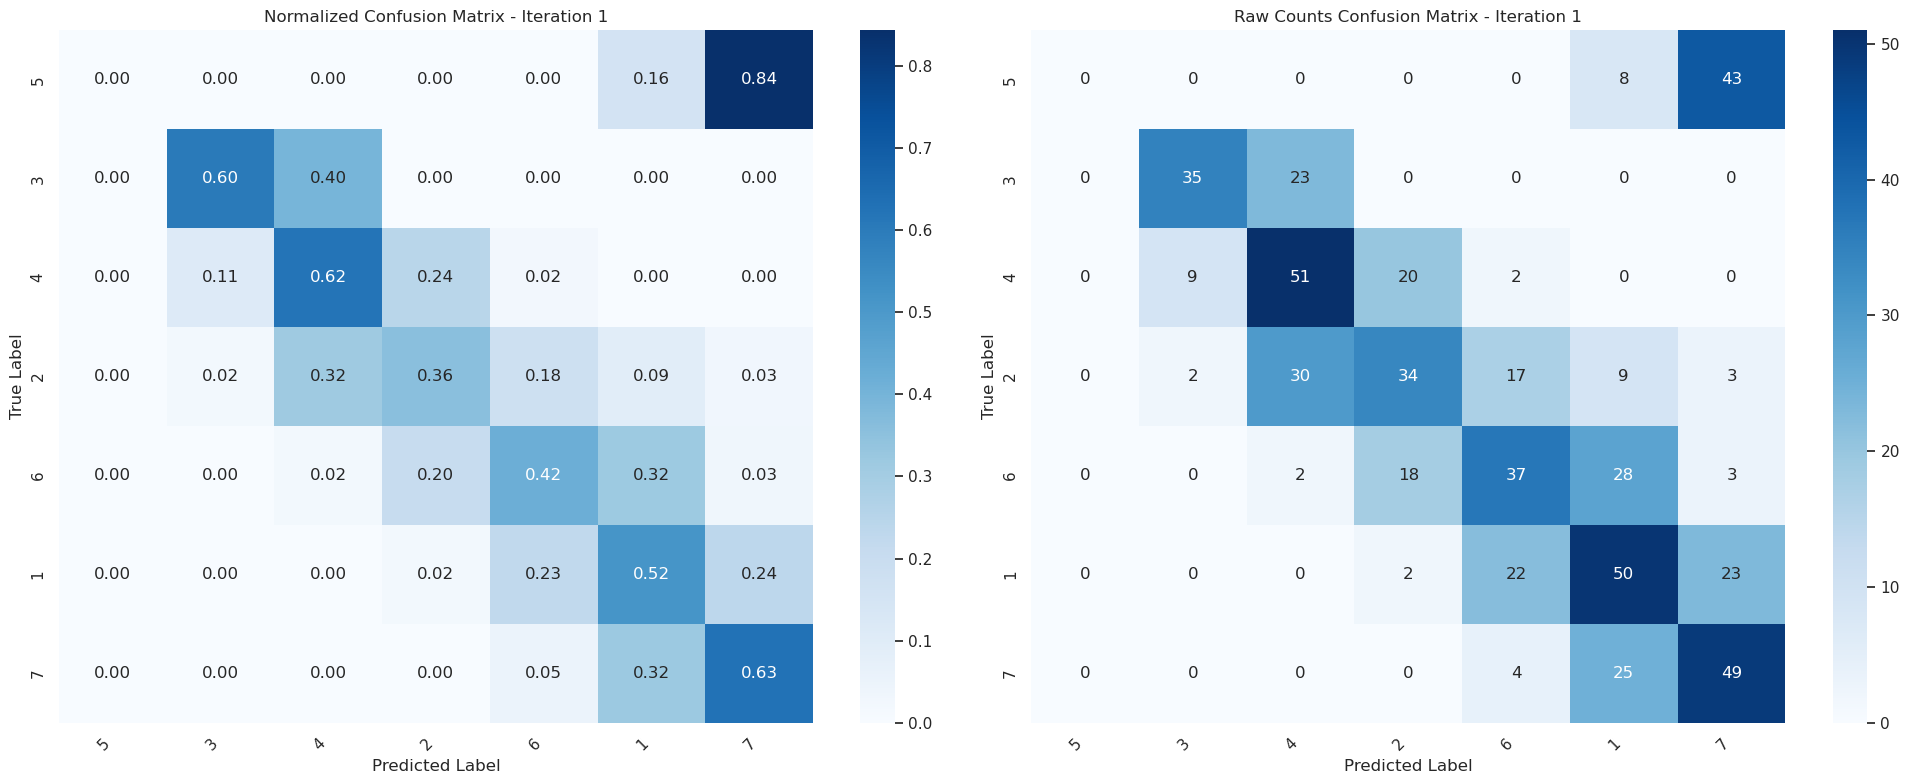

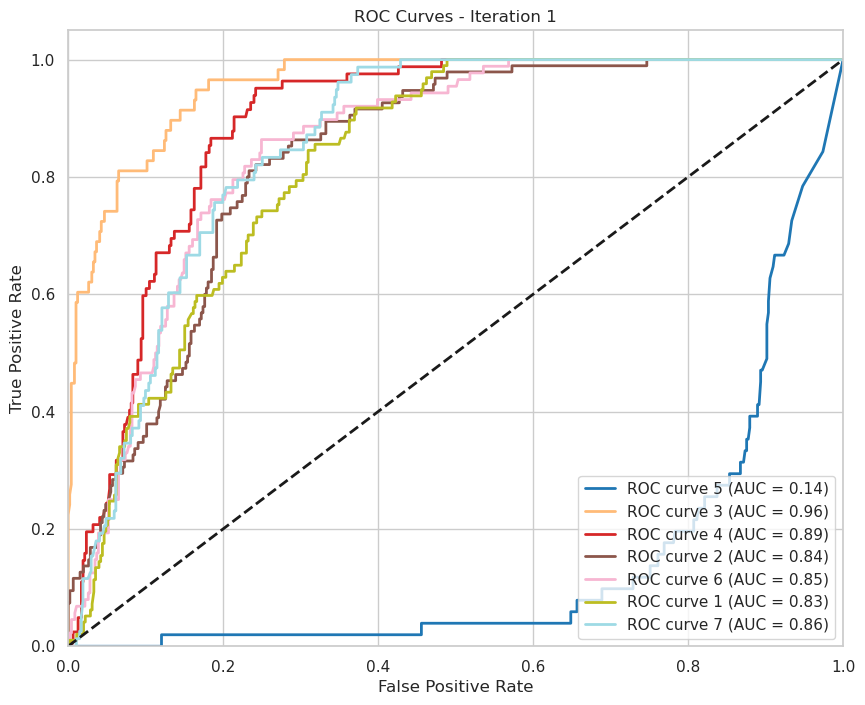

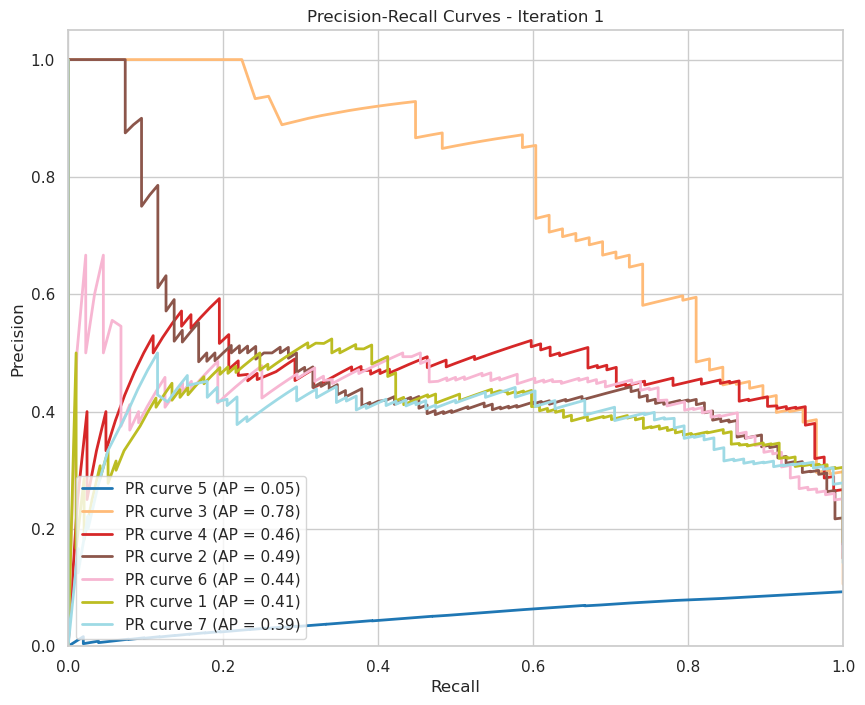

INFO:__main__:Collected 646 images for class 5
INFO:__main__:Collected 635 images for class 3
INFO:__main__:Collected 584 images for class 4
INFO:__main__:Collected 543 images for class 2
INFO:__main__:Collected 522 images for class 6
INFO:__main__:Collected 385 images for class 1
INFO:__main__:Collected 342 images for class 7
INFO:__main__:Collected 241 images for class 8
INFO:__main__:Collected 206 images for class 0
INFO:__main__:Split sizes - Train: 2872, Val: 616, Test: 616
INFO:__main__:Training set class distribution:
class
5    452
3    445
4    408
2    379
6    366
1    269
7    240
8    169
0    144
Name: count, dtype: int64



==================== Iteration 2 ====================
Previous classes: ['5', '3', '4', '2', '6', '1', '7']
New classes: ['8', '0']
Dataset manager classes: 9
Class weights: {5: 0.7058823529411765, 3: 0.7181102362204724, 4: 0.7808219178082192, 2: 0.8397790055248618, 6: 0.8735632183908046, 1: 1.1844155844155844, 7: 1.3333333333333333, 8: 3.784232365145228, 0: 4.427184466019417}
Training on classes: ['5', '3', '4', '2', '6', '1', '7', '8', '0']


INFO:__main__:Loaded best model from iteration 1
INFO:__main__:Prepared next iteration with 9 classes from iteration 1


Epoch 1/100
18/90 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5437 - loss: 4.6260 - sparse_f1_score: 0.5653

E0000 00:00:1732731104.160902   41286 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732731104.360428   41286 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5538 - loss: 3.8118 - sparse_f1_score: 0.5651

2024-11-27 12:11:53.158919: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1786', 4 bytes spill stores, 4 bytes spill loads

2024-11-27 12:11:53.343831: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1797', 12 bytes spill stores, 12 bytes spill loads

2024-11-27 12:11:53.585547: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1797', 4 bytes spill stores, 4 bytes spill loads

E0000 00:00:1732731116.948671   41282 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732731117.153765   41282 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-


Epoch 1: val_accuracy improved from -inf to 0.49351, saving model to saved_models/best_model_iter_2.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 300ms/step - accuracy: 0.5540 - loss: 3.7804 - sparse_f1_score: 0.5651 - val_accuracy: 0.4935 - val_loss: 1.1944 - val_sparse_f1_score: 0.5680 - learning_rate: 1.0000e-04
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6035 - loss: 0.7597 - sparse_f1_score: 0.5876
Epoch 2: val_accuracy improved from 0.49351 to 0.68182, saving model to saved_models/best_model_iter_2.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6034 - loss: 0.7590 - sparse_f1_score: 0.5877 - val_accuracy: 0.6818 - val_loss: 0.5311 - val_sparse_f1_score: 0.6261 - learning_rate: 1.0000e-04
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6235 - loss: 0.5283 - sparse_f1_score: 0.6363
Epoch 3: val_accuracy improved from 0.68182 to 0.69805, saving model to saved_models/best_model_iter_2.keras
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accurac

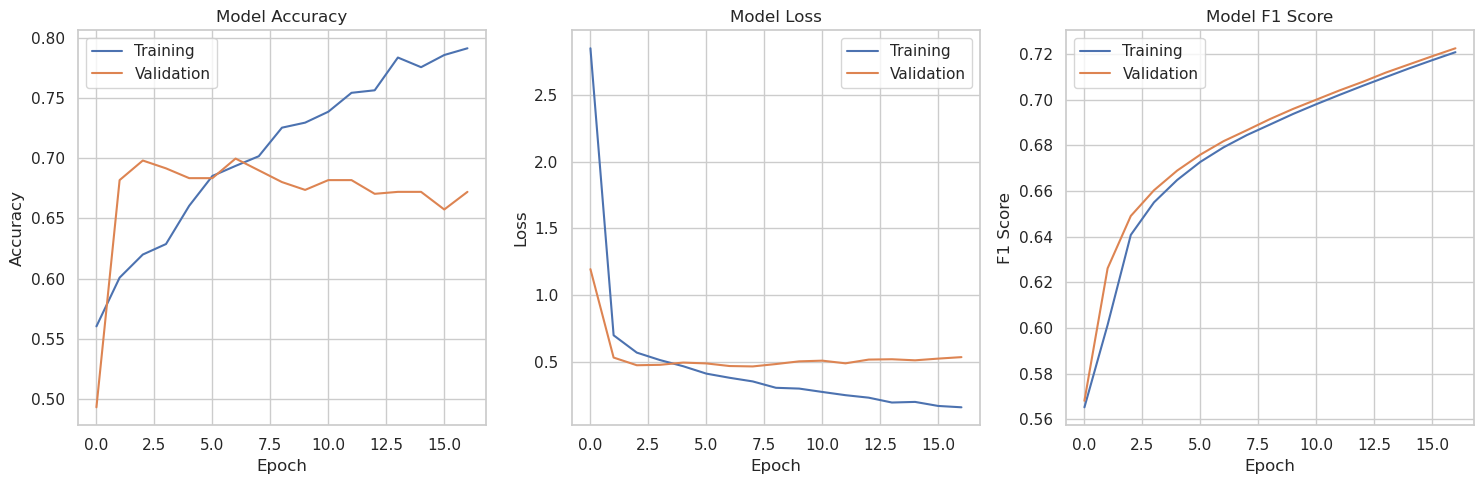

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


2024-11-27 12:13:37.559352: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels

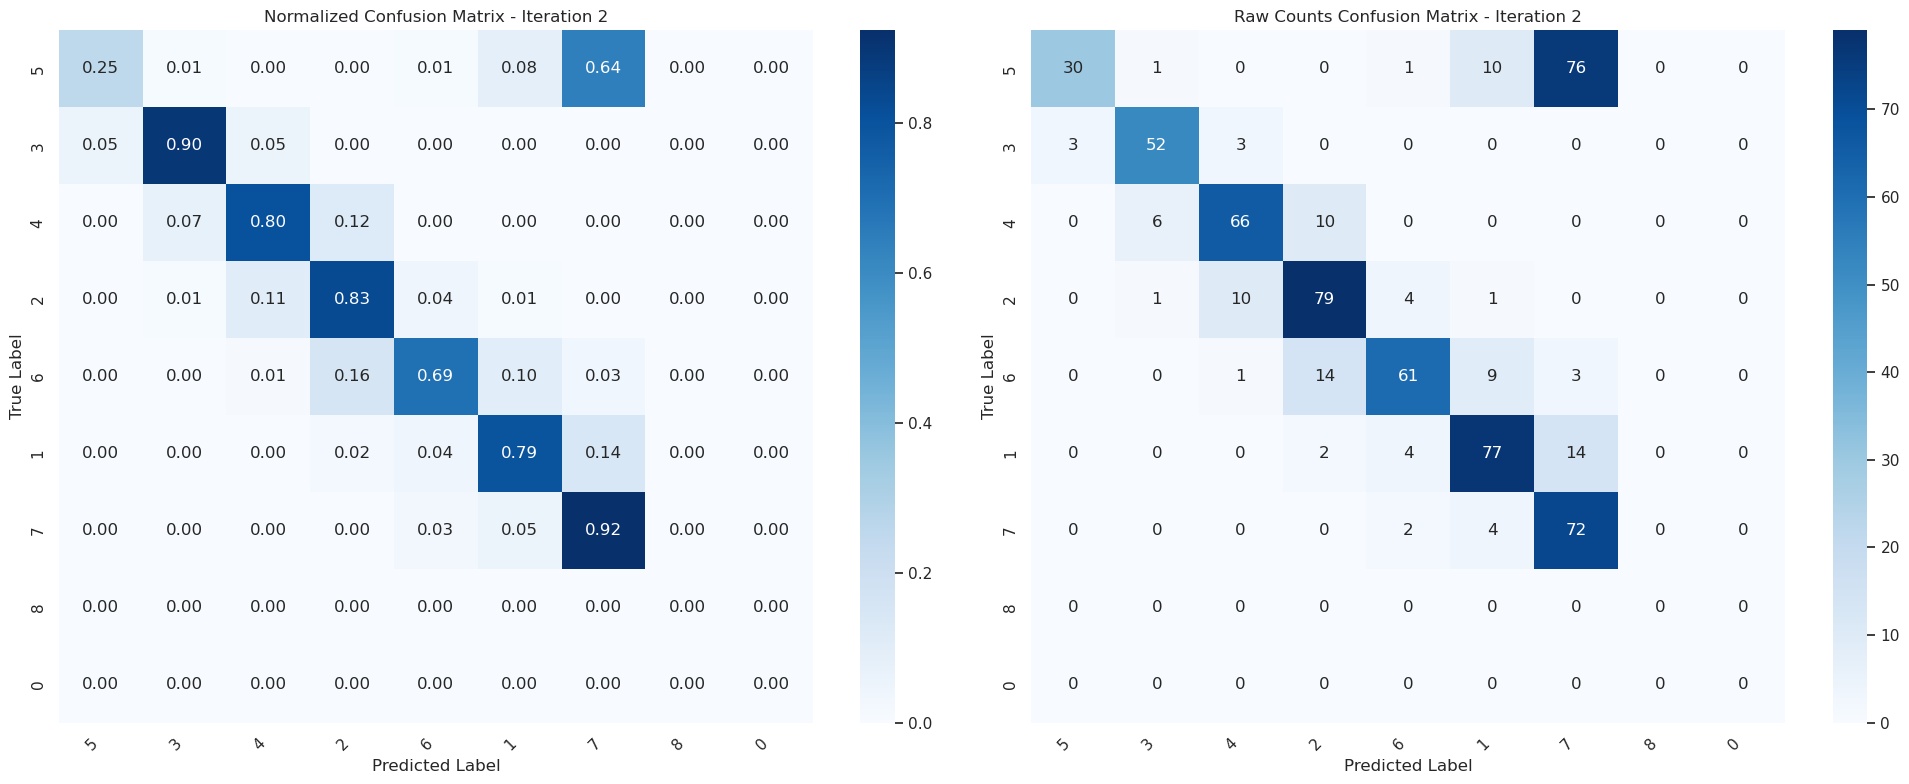

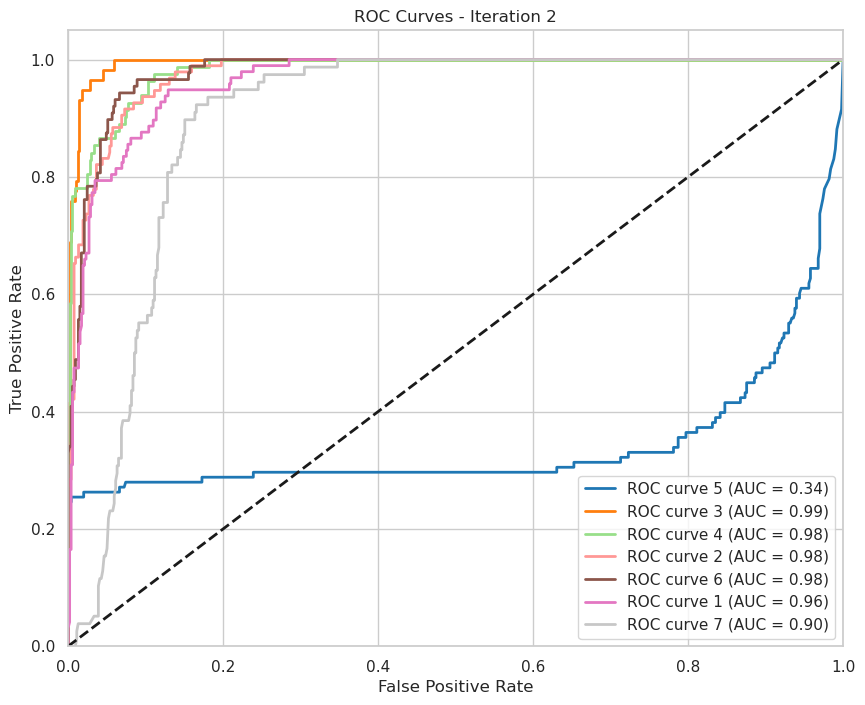

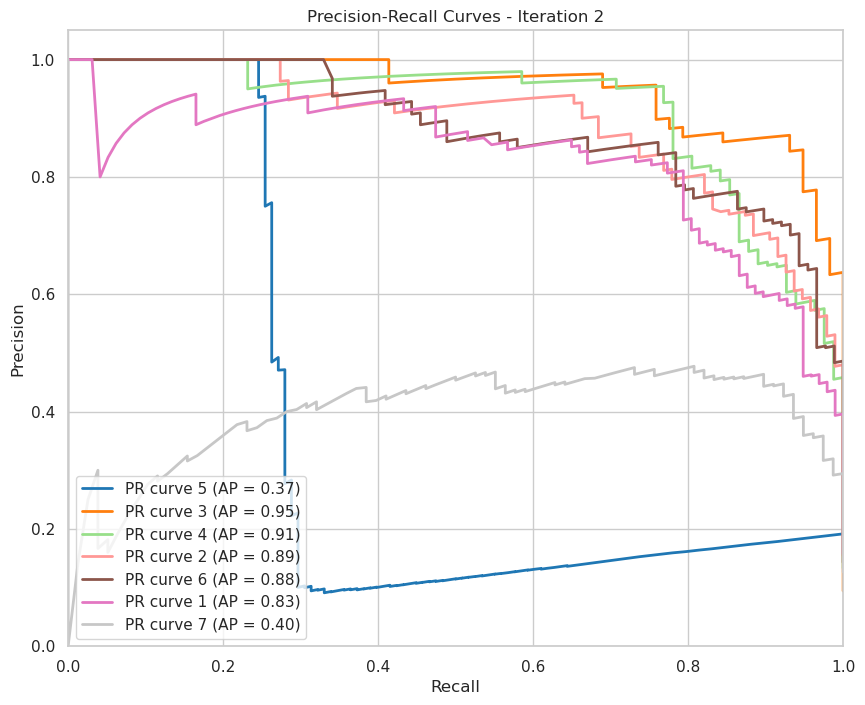

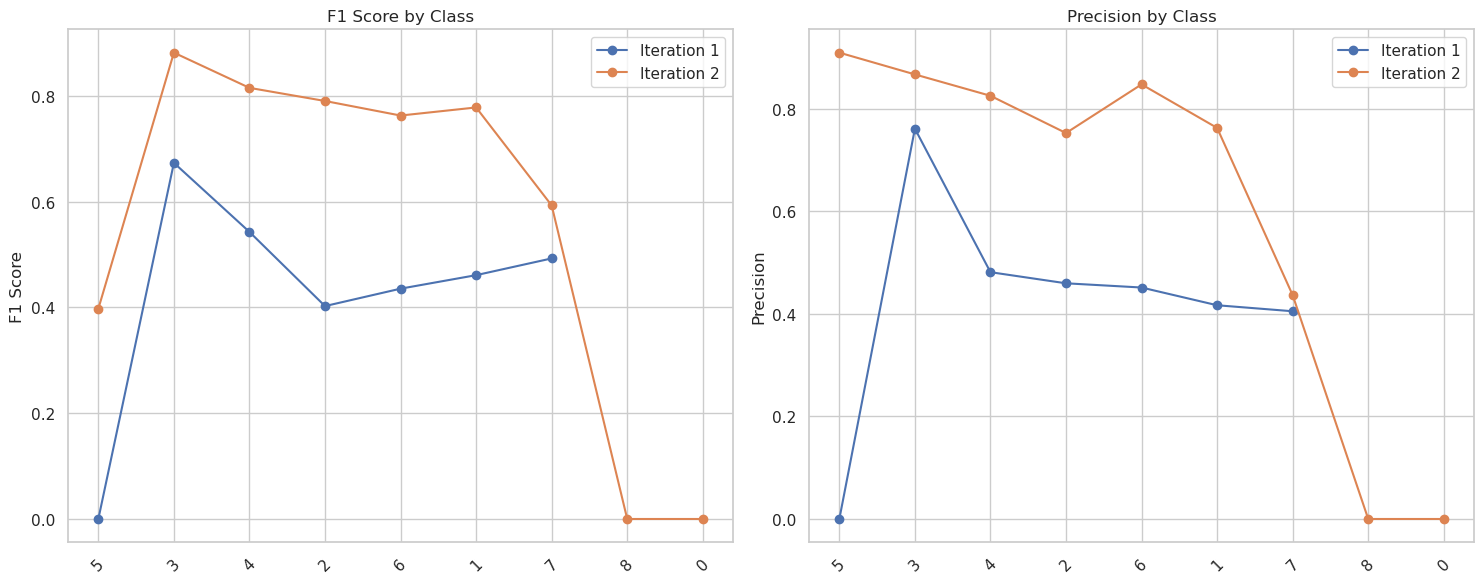

INFO:__main__:Collected 646 images for class 5
INFO:__main__:Collected 635 images for class 3
INFO:__main__:Collected 584 images for class 4
INFO:__main__:Collected 543 images for class 2
INFO:__main__:Collected 522 images for class 6
INFO:__main__:Collected 385 images for class 1
INFO:__main__:Collected 342 images for class 7
INFO:__main__:Collected 241 images for class 8
INFO:__main__:Collected 206 images for class 0
INFO:__main__:Collected 155 images for class 9
INFO:__main__:Collected 67 images for class 10
INFO:__main__:Split sizes - Train: 3028, Val: 649, Test: 649
INFO:__main__:Training set class distribution:
class
5     452
3     445
4     408
2     379
6     366
1     269
7     240
8     169
0     144
9     109
10     47
Name: count, dtype: int64



==================== Iteration 3 ====================
Previous classes: ['5', '3', '4', '2', '6', '1', '7', '8', '0']
New classes: ['9', '10']
Dataset manager classes: 11
Class weights: {5: 0.6087813115676893, 3: 0.61932712956335, 4: 0.6734122042341221, 2: 0.7242591662481165, 6: 0.7533960292580982, 1: 1.0214876033057851, 7: 1.1499202551834131, 8: 1.6318370426254243, 0: 1.9090909090909092, 9: 5.074486803519061, 10: 11.739484396200814}
Training on classes: ['5', '3', '4', '2', '6', '1', '7', '8', '0', '9', '10']


INFO:__main__:Loaded best model from iteration 2
INFO:__main__:Prepared next iteration with 11 classes from iteration 2


Epoch 1/100
68/95 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6054 - loss: 0.3255 - sparse_f1_score: 0.7227

E0000 00:00:1732731243.588858   41281 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732731243.813745   41281 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732731244.037098   41281 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


91/95 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6107 - loss: 0.3330 - sparse_f1_score: 0.7228

2024-11-27 12:14:13.457235: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1786', 4 bytes spill stores, 4 bytes spill loads

2024-11-27 12:14:13.608233: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1797', 4 bytes spill stores, 4 bytes spill loads

2024-11-27 12:14:14.291367: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1797', 12 bytes spill stores, 12 bytes spill loads

E0000 00:00:1732731257.756720   41283 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732731257.954834   41283 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-


Epoch 1: val_accuracy improved from -inf to 0.74268, saving model to saved_models/best_model_iter_3.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 40s 264ms/step - accuracy: 0.6116 - loss: 0.3341 - sparse_f1_score: 0.7228 - val_accuracy: 0.7427 - val_loss: 0.2331 - val_sparse_f1_score: 0.7234 - learning_rate: 1.0000e-04
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6199 - loss: 0.3446 - sparse_f1_score: 0.7237
Epoch 2: val_accuracy did not improve from 0.74268
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6200 - loss: 0.3444 - sparse_f1_score: 0.7237 - val_accuracy: 0.7350 - val_loss: 0.2545 - val_sparse_f1_score: 0.7244 - learning_rate: 1.0000e-04
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6431 - loss: 0.3052 - sparse_f1_score: 0.7248
Epoch 3: val_accuracy did not improve from 0.74268
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6432 - loss: 0.3052 - sparse_f1_score: 0.7248 - val_accuracy: 0.7180 - val_loss: 0.2506 - val_sparse_f1_score: 

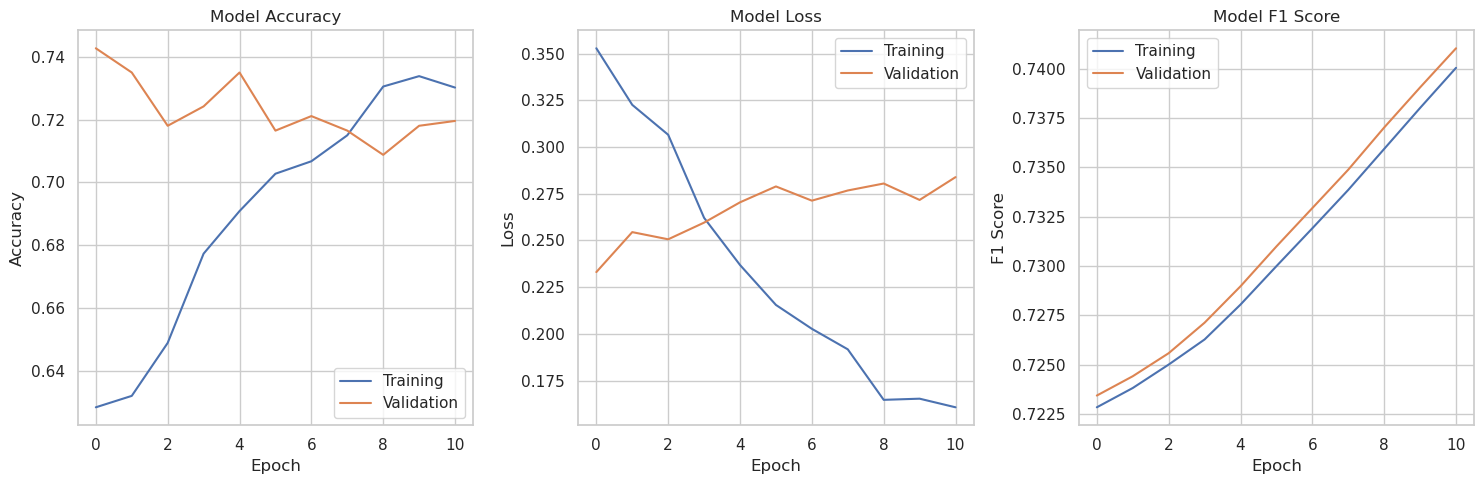

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

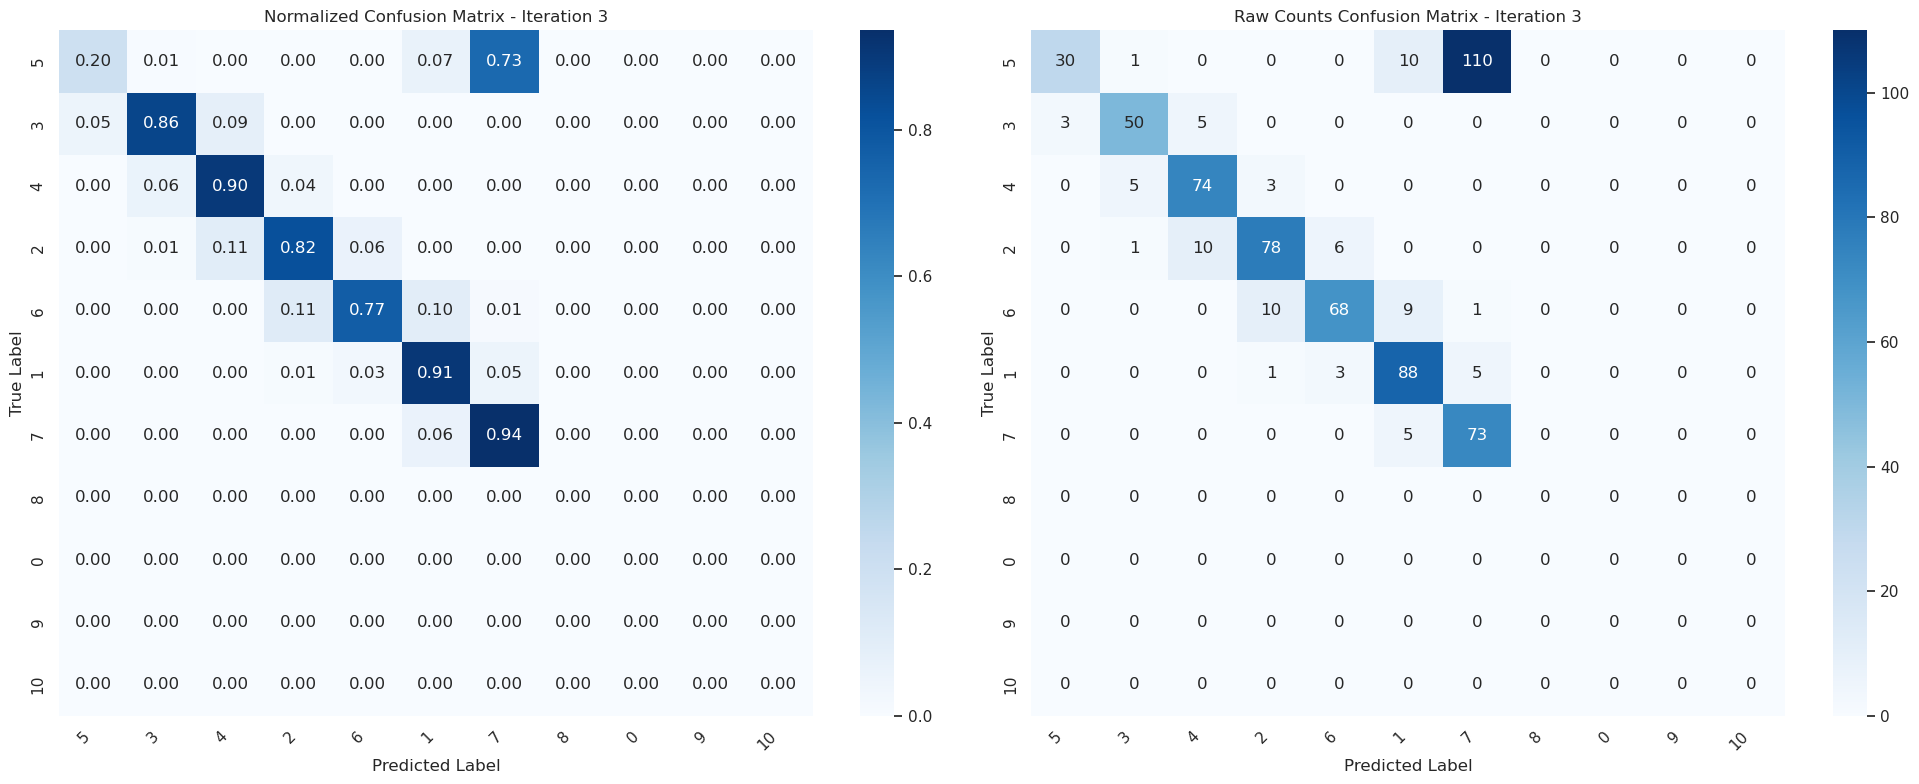

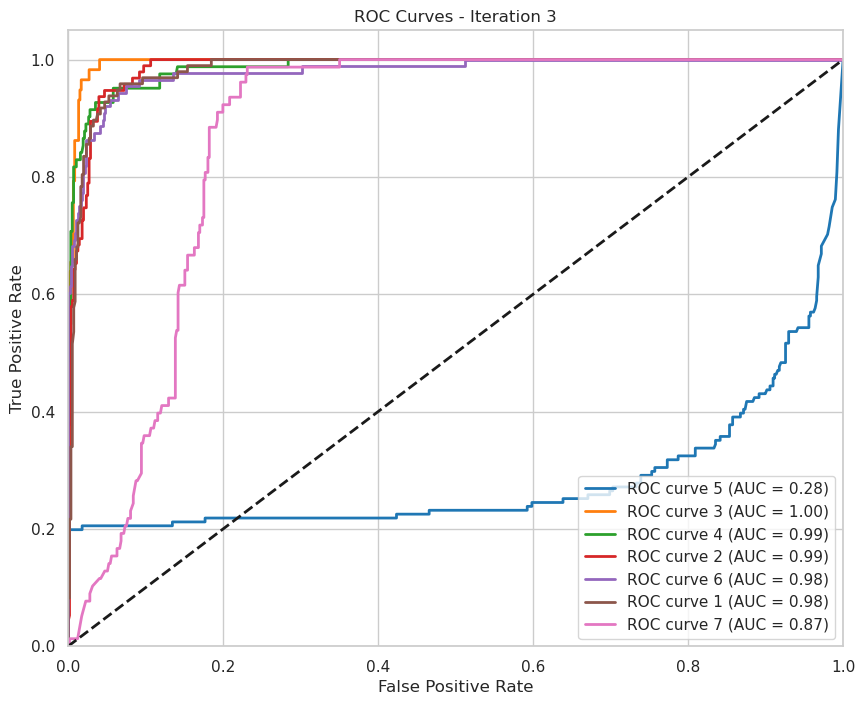

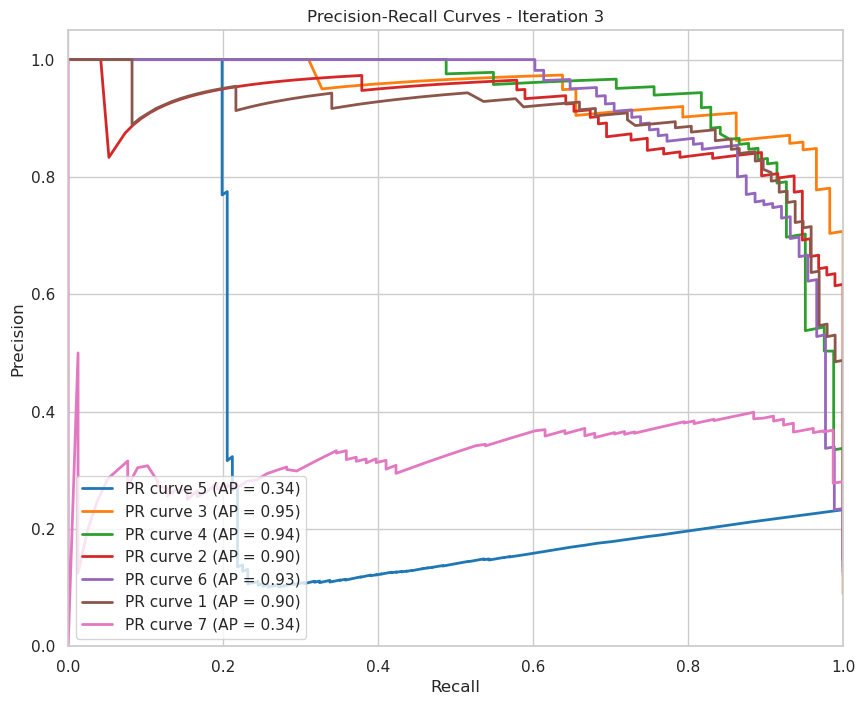

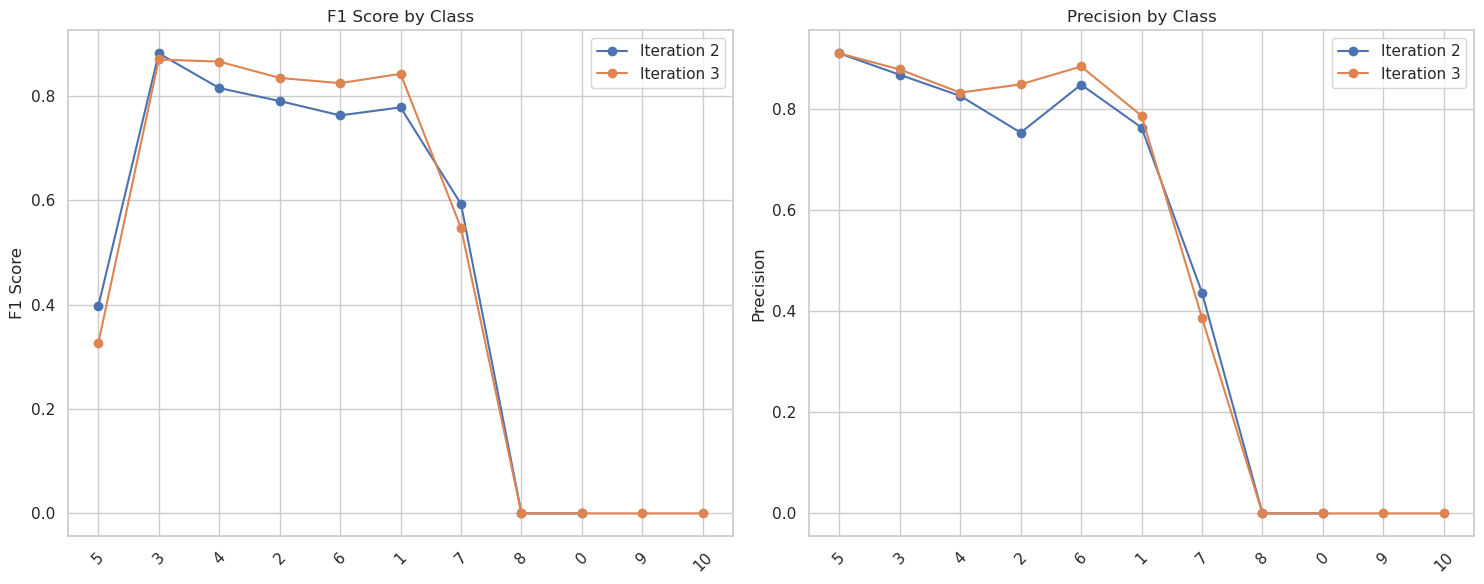

INFO:__main__:Collected 646 images for class 5
INFO:__main__:Collected 635 images for class 3
INFO:__main__:Collected 584 images for class 4
INFO:__main__:Collected 543 images for class 2
INFO:__main__:Collected 522 images for class 6
INFO:__main__:Collected 385 images for class 1
INFO:__main__:Collected 342 images for class 7
INFO:__main__:Collected 241 images for class 8
INFO:__main__:Collected 206 images for class 0
INFO:__main__:Collected 155 images for class 9
INFO:__main__:Collected 67 images for class 10
INFO:__main__:Collected 37 images for class 11
INFO:__main__:Collected 5 images for class 12
INFO:__main__:Split sizes - Train: 3056, Val: 656, Test: 656
INFO:__main__:Training set class distribution:
class
5     452
3     445
4     408
2     379
6     366
1     269
7     240
8     169
0     144
9     109
10     47
11     25
12      3
Name: count, dtype: int64



==================== Iteration 4 ====================
Previous classes: ['5', '3', '4', '2', '6', '1', '7', '8', '0', '9', '10']
New classes: ['11', '12']
Dataset manager classes: 13
Class weights: {5: 0.5201238390092879, 3: 0.5291338582677165, 4: 0.5753424657534246, 2: 0.6187845303867403, 6: 0.6436781609195402, 1: 0.8727272727272727, 7: 0.9824561403508771, 8: 1.3941908713692945, 0: 1.6310679611650485, 9: 2.167741935483871, 10: 5.014925373134329, 11: 18.16216216216216, 12: 134.4}
Training on classes: ['5', '3', '4', '2', '6', '1', '7', '8', '0', '9', '10', '11', '12']


INFO:__main__:Loaded best model from iteration 3
INFO:__main__:Prepared next iteration with 13 classes from iteration 3


Epoch 1/100
12/96 ━━━━━━━━━━━━━━━━━━━━ 25s 299ms/step - accuracy: 0.5503 - loss: 0.2994 - sparse_f1_score: 0.7411

E0000 00:00:1732731340.443251   41283 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732731340.671591   41283 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732731340.877687   41283 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6025 - loss: 0.2928 - sparse_f1_score: 0.7411

2024-11-27 12:15:50.061216: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1786', 8 bytes spill stores, 8 bytes spill loads

2024-11-27 12:15:50.148485: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1797', 12 bytes spill stores, 12 bytes spill loads

2024-11-27 12:15:50.287157: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1797', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.74238, saving model to saved_models/best_model_iter_4.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 33s 222ms/step - accuracy: 0.6026 - loss: 0.2929 - sparse_f1_score: 0.7411 - val_accuracy: 0.7424 - val_loss: 0.2411 - val_sparse_f1_score: 0.7410 - learning_rate: 1.0000e-04
Epoch 2/100
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6604 - loss: 0.2544 - sparse_f1_score: 0.7413
Epoch 2: val_accuracy did not improve from 0.74238
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6594 - loss: 0.2551 - sparse_f1_score: 0.7413 - val_accuracy: 0.7302 - val_loss: 0.2642 - val_sparse_f1_score: 0.7415 - learning_rate: 1.0000e-04
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6619 - loss: 0.2304 - sparse_f1_score: 0.7418
Epoch 3: val_accuracy did not improve from 0.74238
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6619 - loss: 0.2304 - sparse_f1_score: 0.7418 - val_accuracy: 0.7317 - val_loss: 0.2573 - val_sparse_f1_score: 

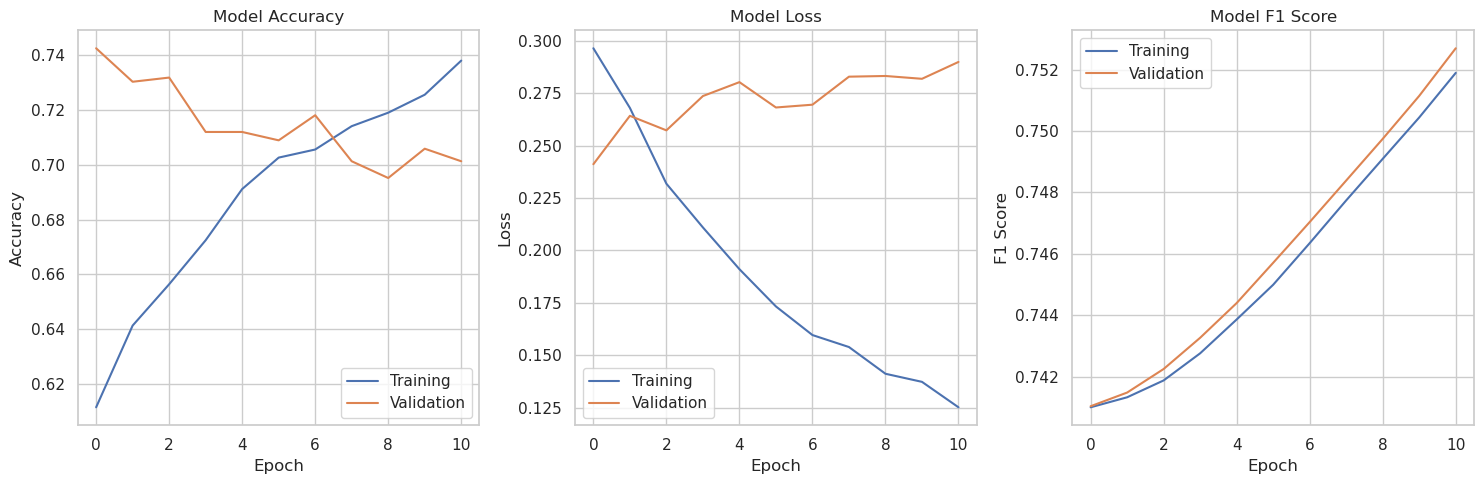

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


2024-11-27 12:16:54.899952: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/carlos/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels

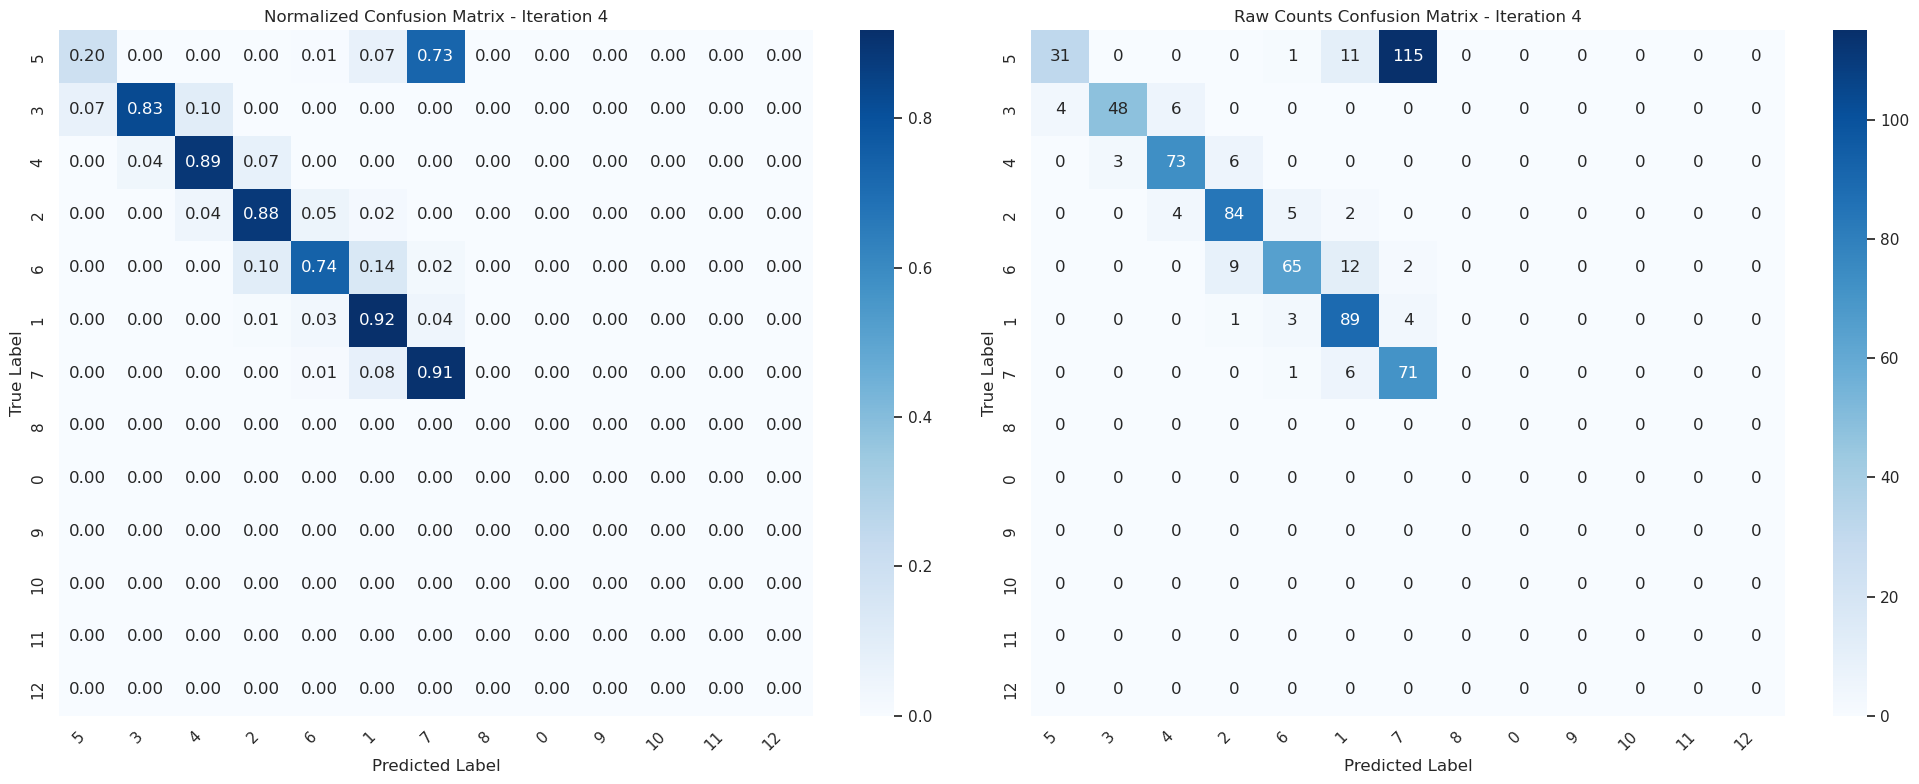

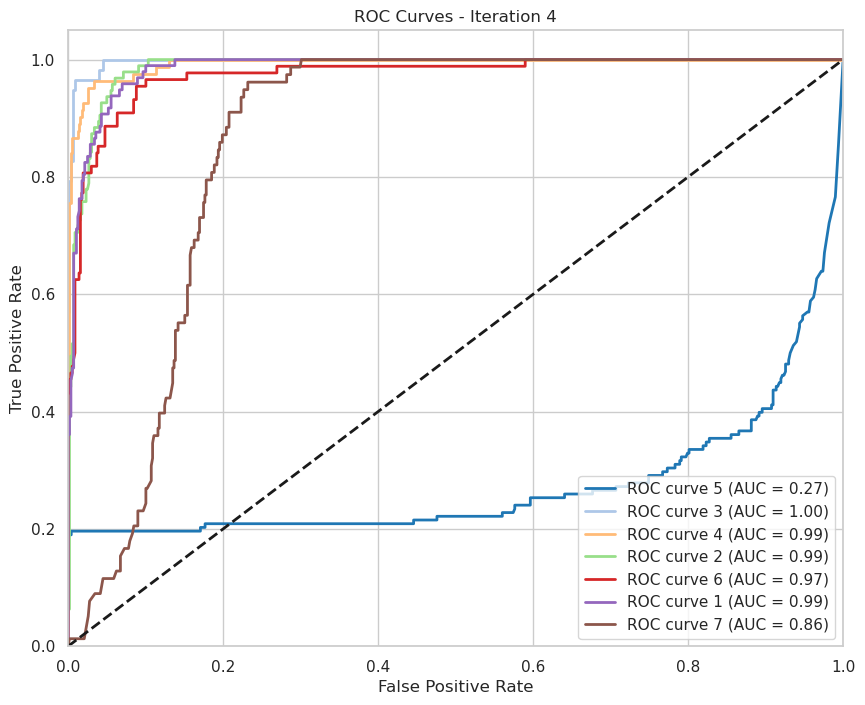

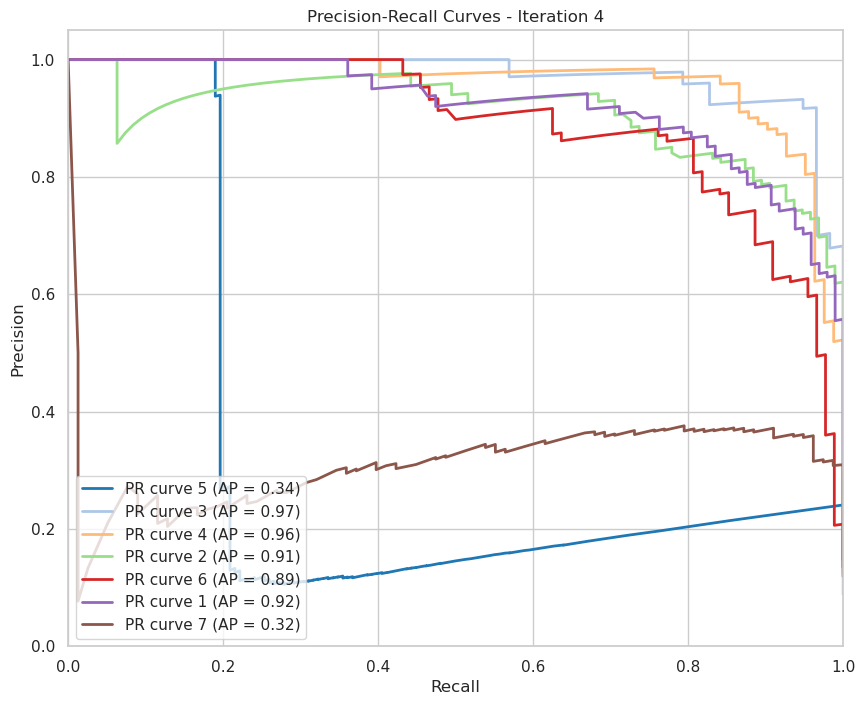

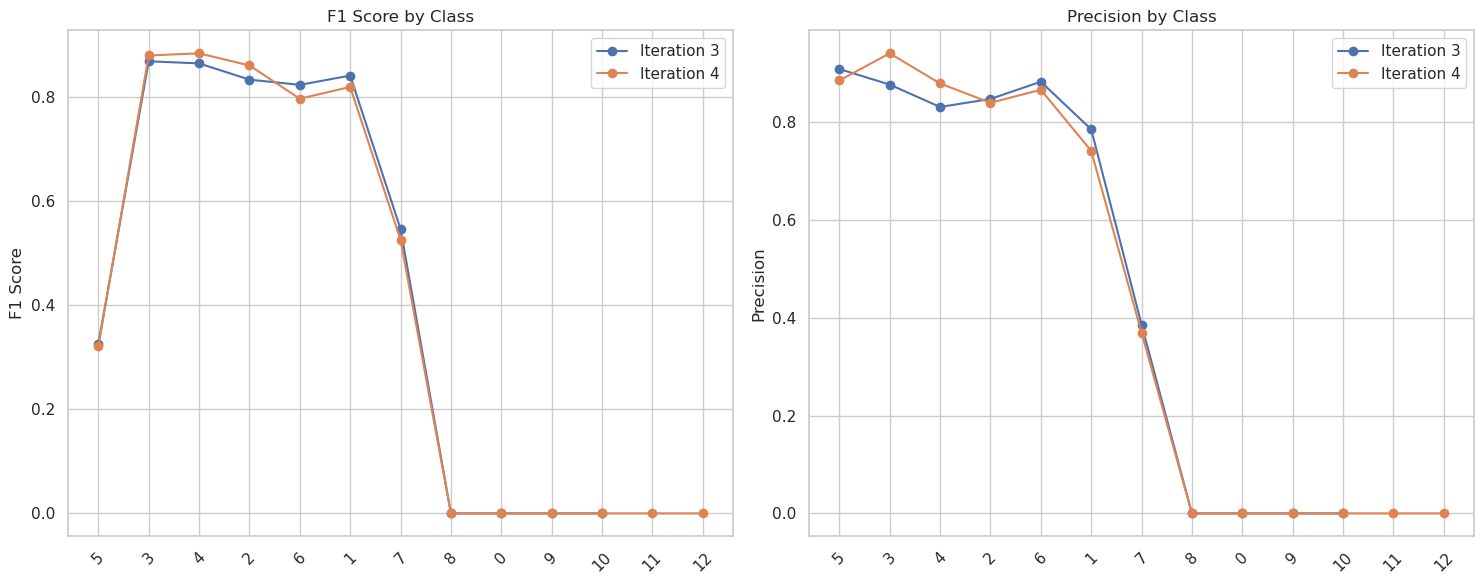

In [41]:
train_iteratively(
    dataset_manager=dataset_manager,
    model_manager=model_manager,
    data_generator=data_generator,
    evaluator=evaluator,
    initial_class_count=7,
    final_classes_count=13,
    classes_per_iteration=2,
    epochs=100,
)